# SEC Disclosure-Risk Monitor: Signal QC

This notebook explores filing patterns in our SEC database to understand:
- Normal filing behavior
- Potential anomalies
- Key features for detection

In [9]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [10]:
# Load data from SQLite database
db_path = Path.cwd().parent / "data" / "sec_anomaly.db"

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

# Load filings and companies
filings = pd.read_sql_query("SELECT * FROM filing_events", conn)
companies = pd.read_sql_query("SELECT * FROM companies", conn)

conn.close()

# Convert date columns to datetime (handle mixed ISO8601 formats)
filings['filed_at'] = pd.to_datetime(filings['filed_at'], format='mixed', utc=True)
companies['updated_at'] = pd.to_datetime(companies['updated_at'], format='mixed', utc=True)

print(f"✅ Loaded {len(companies)} companies and {len(filings)} filings")
print(f"\nDate range: {filings['filed_at'].min()} to {filings['filed_at'].max()}")
print(f"Filing types: {filings['filing_type'].unique().tolist()}")

✅ Loaded 100 companies and 802 filings

Date range: 2025-08-11 20:20:29+00:00 to 2026-02-11 11:35:11+00:00
Filing types: ['10-Q', '8-K', '10-K', '10-K/A', '8-K/A']


## 1. Filing Volume by Company

Which companies file most frequently? Anomalies often have unusual filing patterns.

Top 10 companies by filing count:
   ticker                         name  filing_count
78  CMCSA                 COMCAST CORP            19
61    COF   CAPITAL ONE FINANCIAL CORP            17
16   INTC                   INTEL CORP            16
34    WMT                 Walmart Inc.            14
45     VZ   VERIZON COMMUNICATIONS INC            14
67    AMT     AMERICAN TOWER CORP /MA/            14
2     AXP          AMERICAN EXPRESS CO            13
27     PG          PROCTER & GAMBLE Co            13
49    HON  HONEYWELL INTERNATIONAL INC            13
73    MET                  METLIFE INC            13


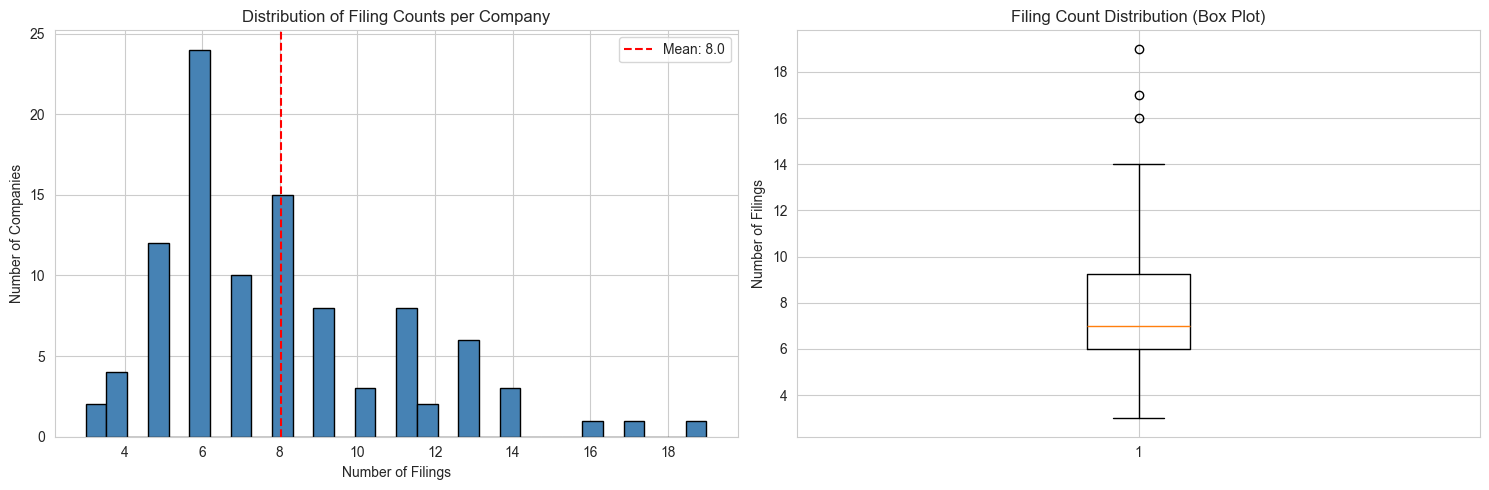


🚨 3 companies with unusual filing counts (potential anomalies)
   ticker                        name  filing_count
78  CMCSA                COMCAST CORP            19
61    COF  CAPITAL ONE FINANCIAL CORP            17
16   INTC                  INTEL CORP            16


In [11]:
# Filing count per company
filing_counts = filings.groupby('cik').size().reset_index(name='filing_count')
filing_counts = filing_counts.merge(companies[['cik', 'name', 'ticker']], on='cik', how='left')

print("Top 10 companies by filing count:")
print(filing_counts.nlargest(10, 'filing_count')[['ticker', 'name', 'filing_count']])

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(filing_counts['filing_count'], bins=30, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Number of Filings')
axes[0].set_ylabel('Number of Companies')
axes[0].set_title('Distribution of Filing Counts per Company')
axes[0].axvline(filing_counts['filing_count'].mean(), color='red', linestyle='--', label=f'Mean: {filing_counts["filing_count"].mean():.1f}')
axes[0].legend()

# Box plot to spot outliers
axes[1].boxplot(filing_counts['filing_count'])
axes[1].set_ylabel('Number of Filings')
axes[1].set_title('Filing Count Distribution (Box Plot)')

plt.tight_layout()
plt.show()

# Identify outliers (unusually high/low filers)
Q1 = filing_counts['filing_count'].quantile(0.25)
Q3 = filing_counts['filing_count'].quantile(0.75)
IQR = Q3 - Q1
outliers = filing_counts[(filing_counts['filing_count'] < Q1 - 1.5*IQR) | (filing_counts['filing_count'] > Q3 + 1.5*IQR)]
print(f"\n🚨 {len(outliers)} companies with unusual filing counts (potential anomalies)")
print(outliers[['ticker', 'name', 'filing_count']].sort_values('filing_count', ascending=False))

## 2. Filing Type Distribution

Which filing types appear most? Are there type anomalies (e.g., unusual form types)?

Filing type distribution (normalized):
filing_type_norm
8-K       636
10-Q      113
10-K       41
8-K/A      11
10-K/A      1
Name: count, dtype: int64


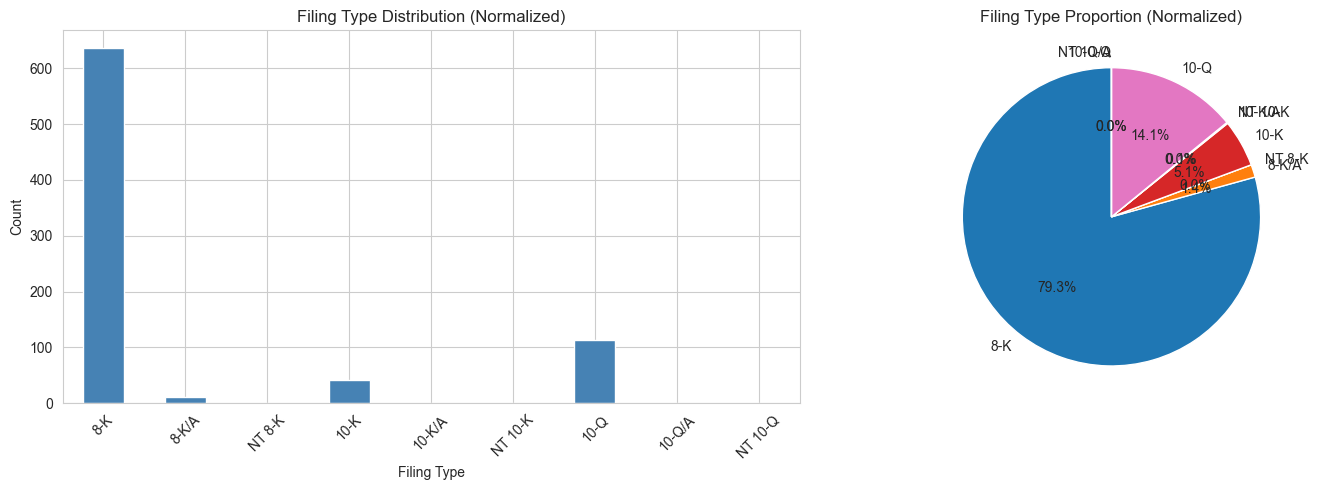

In [12]:
# Normalize filing types to capture amendments and NT forms
def normalize_filing_type(filing_type: str) -> str:
    if filing_type is None:
        return "Unknown"
    filing_type = filing_type.strip()
    if filing_type.startswith("NT "):
        base = filing_type.replace("NT ", "", 1).strip()
        return f"NT {base}"
    if filing_type.endswith("/A"):
        base = filing_type[:-2]
        return f"{base}/A"
    if filing_type.endswith("-A"):
        base = filing_type[:-2]
        return f"{base}/A"
    return filing_type

filings['filing_type_norm'] = filings['filing_type'].apply(normalize_filing_type)

filing_type_counts = filings['filing_type_norm'].value_counts()

print("Filing type distribution (normalized):")
print(filing_type_counts)

# Focus on core forms and their NT / amendment variants
focus_types = [
    "8-K", "8-K/A", "NT 8-K",
    "10-K", "10-K/A", "NT 10-K",
    "10-Q", "10-Q/A", "NT 10-Q",
]

focus_counts = filing_type_counts.reindex(focus_types).fillna(0).astype(int)
other_count = filing_type_counts.drop(focus_types, errors="ignore").sum()
if other_count > 0:
    focus_counts.loc["Other"] = int(other_count)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
focus_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Filing Type Distribution (Normalized)')
axes[0].set_xlabel('Filing Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(focus_counts.values, labels=focus_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Filing Type Proportion (Normalized)')

plt.tight_layout()
plt.show()


## 3. Filing Frequency Over Time

Is filing activity uniform or do we see patterns/spikes?

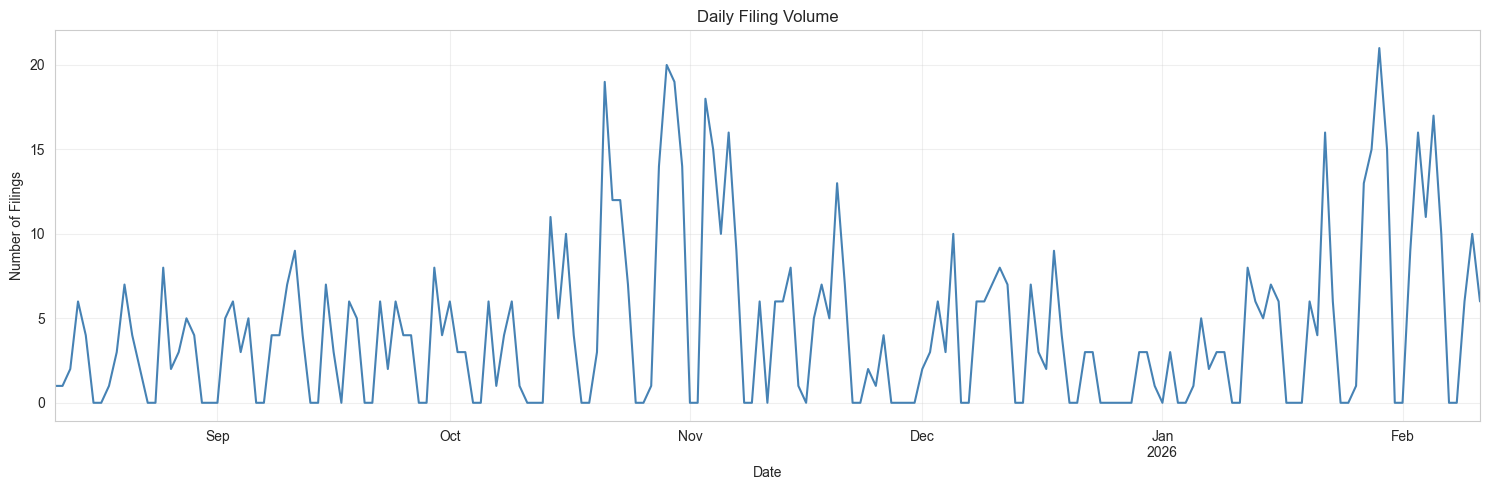


Daily filing statistics:
  Mean: 4.3 filings/day
  Std Dev: 4.9
  Max: 21 (date: 2026-01-29 00:00:00+00:00)
  Min: 0 (date: 2025-08-16 00:00:00+00:00)


In [13]:
# Daily filing count
daily_filings = filings.set_index('filed_at').resample('D').size()

fig, ax = plt.subplots(figsize=(15, 5))
daily_filings.plot(ax=ax, color='steelblue', linewidth=1.5)
ax.set_title('Daily Filing Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Filings')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDaily filing statistics:")
print(f"  Mean: {daily_filings.mean():.1f} filings/day")
print(f"  Std Dev: {daily_filings.std():.1f}")
print(f"  Max: {daily_filings.max()} (date: {daily_filings.idxmax()})")
print(f"  Min: {daily_filings.min()} (date: {daily_filings.idxmin()})")

## 4. Inter-Filing Gap Analysis

How long does it take companies to file between submissions? Unusual gaps = anomalies.

Inter-filing gap statistics (in days):
  Mean: 18.6 days
  Median: 10.0 days
  Std Dev: 21.5 days
  Min: 0 days
  Max: 97 days


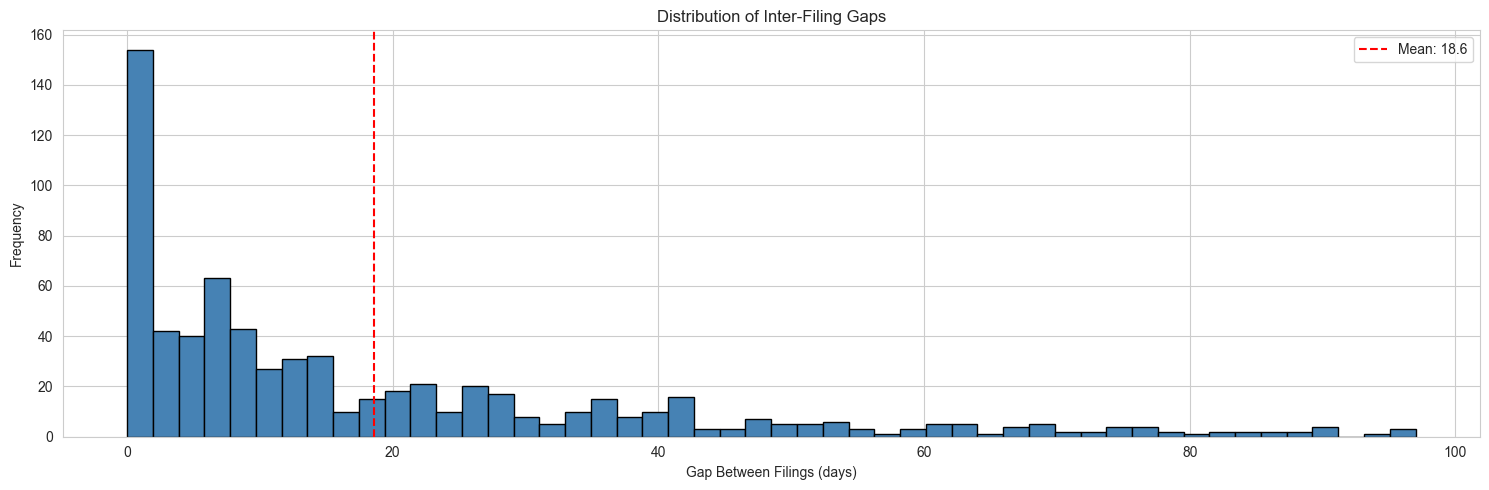


🚨 Filing gaps > 68 days (95th percentile) = potential anomalies


In [14]:
# Calculate gaps between consecutive filings per company
gaps = []

for cik in filings['cik'].unique():
    company_filings = filings[filings['cik'] == cik].sort_values('filed_at')
    if len(company_filings) > 1:
        company_filings_sorted = company_filings.reset_index(drop=True)
        for i in range(len(company_filings_sorted) - 1):
            gap = (company_filings_sorted.iloc[i+1]['filed_at'] - company_filings_sorted.iloc[i]['filed_at']).days
            gaps.append(gap)

gaps_series = pd.Series(gaps)

print("Inter-filing gap statistics (in days):")
print(f"  Mean: {gaps_series.mean():.1f} days")
print(f"  Median: {gaps_series.median():.1f} days")
print(f"  Std Dev: {gaps_series.std():.1f} days")
print(f"  Min: {gaps_series.min()} days")
print(f"  Max: {gaps_series.max()} days")

fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(gaps_series, bins=50, edgecolor='black', color='steelblue')
ax.set_xlabel('Gap Between Filings (days)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inter-Filing Gaps')
ax.axvline(gaps_series.mean(), color='red', linestyle='--', label=f'Mean: {gaps_series.mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

# Identify unusually long gaps
long_gaps_threshold = gaps_series.quantile(0.95)
print(f"\n🚨 Filing gaps > {long_gaps_threshold:.0f} days (95th percentile) = potential anomalies")

## 5. Day-of-Week & Hour Analysis

Do companies file on specific days/times? Unusual timing = anomalies.

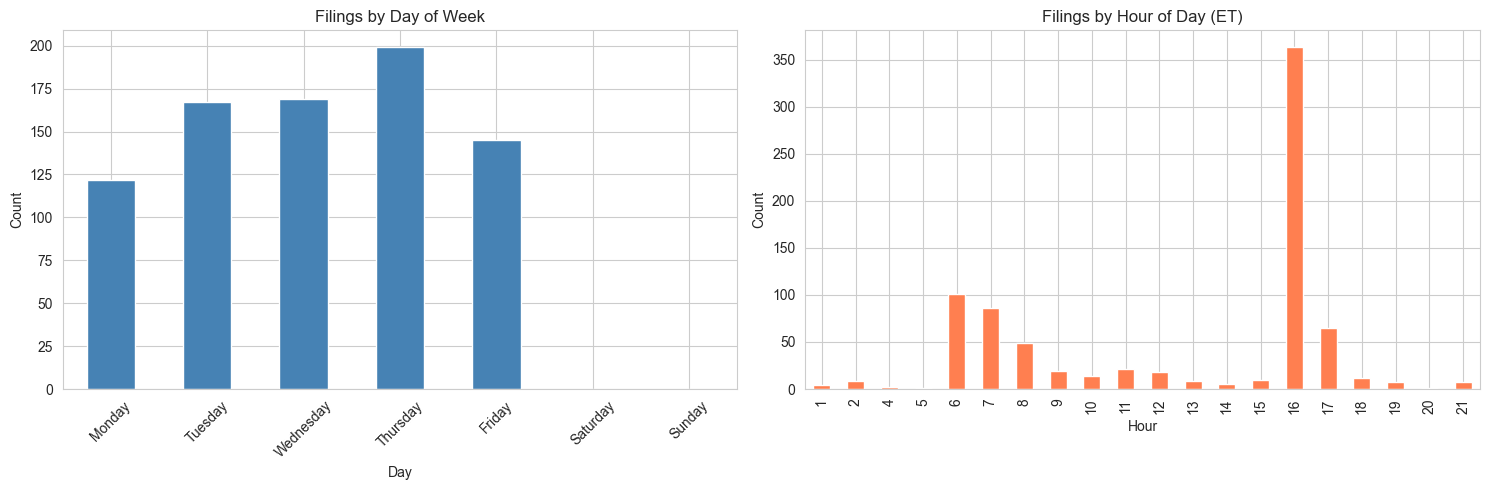

Filings by day of week:
dayofweek
Monday       122.0
Tuesday      167.0
Wednesday    169.0
Thursday     199.0
Friday       145.0
Saturday       NaN
Sunday         NaN
Name: count, dtype: float64

Filings by hour:
hour
1       4
2       8
4       2
5       1
6     101
7      86
8      49
9      19
10     14
11     21
12     18
13      9
14      5
15     10
16    363
17     65
18     12
19      7
20      1
21      7
Name: count, dtype: int64


In [15]:
filings['filed_at'] = pd.to_datetime(filings['filed_at'], utc=True)
filings['filed_at_et'] = filings['filed_at'].dt.tz_convert("US/Eastern")
filings['dayofweek'] = filings['filed_at_et'].dt.day_name()
filings['hour'] = filings['filed_at_et'].dt.hour

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = filings['dayofweek'].value_counts().reindex(day_order)
day_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Filings by Day of Week')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Hour of day
filings['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Filings by Hour of Day (ET)')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("Filings by day of week:")
print(day_counts)
print("\nFilings by hour:")
print(filings['hour'].value_counts().sort_index())

## 6. Key Features for Disclosure-Risk Signals

Based on this EDA, here are the features to track:

In [18]:
features_for_detection = {
    "Filing Frequency": "Unusual filing counts per company (IQR-based outliers)",
    "Inter-Filing Gap": "Abnormally long delays between consecutive filings",
    "Filing Type Mix": "Unusual ratio of 8-K/10-Q/10-K filings, including NT and /A variants",
    "Amendment/NT Rate": "Elevated share of /A or NT filings versus baseline",
    "Temporal Pattern": "Filings outside normal business hours/days",
    "Volume Spike": "Sudden increase in daily filing volume",
    "Company Deviation": "Company filing pattern change from historical baseline",
    "Primary Document": "Missing or anomalous primary_document field"
}

print("FEATURES FOR ANOMALY DETECTION:")
for feature, description in features_for_detection.items():
    print(f"  • {feature}: {description}")

# Save summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS FOR ANOMALY DETECTION")
print("="*60)
print(f"Total companies: {len(companies)}")
print(f"Total filings: {len(filings)}")
print(f"Filing type diversity: {filings['filing_type'].nunique()} types")
print(f"Avg filings/company: {len(filings)/len(companies):.1f}")
print(f"Max gap between filings: {gaps_series.max()} days")
print(f"Companies with >1 filing: {len(filing_counts[filing_counts['filing_count'] > 1])}")
print(f"Filings outside 8-17h ET: {len(filings[~filings['hour'].between(8, 17)])}")
print(f"Filings on weekends: {len(filings[filings['dayofweek'].isin(['Saturday', 'Sunday'])])}")


FEATURES FOR ANOMALY DETECTION:
  • Filing Frequency: Unusual filing counts per company (IQR-based outliers)
  • Inter-Filing Gap: Abnormally long delays between consecutive filings
  • Filing Type Mix: Unusual ratio of 8-K/10-Q/10-K filings, including NT and /A variants
  • Amendment/NT Rate: Elevated share of /A or NT filings versus baseline
  • Temporal Pattern: Filings outside normal business hours/days
  • Volume Spike: Sudden increase in daily filing volume
  • Company Deviation: Company filing pattern change from historical baseline
  • Primary Document: Missing or anomalous primary_document field

SUMMARY STATISTICS FOR ANOMALY DETECTION
Total companies: 100
Total filings: 802
Filing type diversity: 5 types
Avg filings/company: 8.0
Max gap between filings: 97 days
Companies with >1 filing: 100
Filings outside 8-17h ET: 229
Filings on weekends: 0


## 7. 8-K Spike Signal Validation

Validate 8-K monthly spike alerts produced by the detector. This section summarizes
the alerts and shows the strongest spikes for quick spot-checking.


In [ ]:
import json

conn = sqlite3.connect(db_path)
alerts_8k = pd.read_sql_query(
    "SELECT * FROM alerts WHERE anomaly_type = '8K_SPIKE' ORDER BY created_at DESC",
    conn,
)
conn.close()

if alerts_8k.empty:
    print('No 8-K spike alerts yet. Run src/detection/8k_spike_detection.py first.')
else:
    alerts_8k['details'] = alerts_8k['details'].apply(json.loads)
    details_df = pd.json_normalize(alerts_8k['details'])
    merged = pd.concat([alerts_8k.drop(columns=['details']), details_df], axis=1)

    print(f"Total 8-K spike alerts: {len(merged)}")
    cols = [
        'company_ticker',
        'company_name',
        'month',
        'count',
        'baseline_mean',
        'baseline_std',
        'threshold',
        'severity_score',
        'created_at',
    ]
    available_cols = [c for c in cols if c in merged.columns]
    print(merged[available_cols].head(20).to_string(index=False))

    print('
Top spikes by count:')
    print(merged.sort_values('count', ascending=False)[available_cols].head(10).to_string(index=False))
